In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# Function to read the data
def read_data(filename):
    data = pd.read_csv(filename, header=None)
    features = data.iloc[:, :-1].values
    labels = data.iloc[:, -1].values - 1  # Shift the class labels to 0-25
    return features, labels

# Read the data
data_url = "https://raw.githubusercontent.com/UMBInal/data/main/data.csv"
x, y = read_data(data_url)

In [4]:
# Split the data into training, validation, and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [5]:
# Reshape the data
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_val = x_val.reshape((x_val.shape[0], x_val.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

In [6]:
# Determine the input shape and number of classes
input_shape = (x_train.shape[1], 1)
num_classes = len(np.unique(y))

In [7]:
# Transformer Encoder function
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed-forward network
    x = layers.Dense(ff_dim, activation="relu")(res)
    x = layers.Dropout(dropout)(x)

    x = layers.Dense(ff_dim, activation="relu")(x)
    x = layers.Dropout(dropout)(x)

    x = layers.Dense(ff_dim, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    
    x = layers.Dense(ff_dim, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    
    x = layers.Dense(ff_dim, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    
    x = layers.Dense(ff_dim, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    
    x = layers.Dense(ff_dim, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    
    x = layers.Dense(ff_dim, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    
    x = layers.Dense(ff_dim, activation="relu")(x)
    x = layers.Dropout(dropout)(x)

    x = layers.Dense(inputs.shape[-1], activation = 'softmax')(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)

    return x + res

In [8]:
# Transformer Decoder function
def transformer_decoder(inputs, enc_outputs, head_size, num_heads, ff_dim, dropout=0):
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(res, enc_outputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = x + res

    # Feed-forward network
    x = layers.Dense(ff_dim, activation="relu")(x)
    x = layers.Dropout(dropout)(x)

    x = layers.Dense(ff_dim, activation="relu")(x)
    x = layers.Dropout(dropout)(x)

    x = layers.Dense(ff_dim, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    
    x = layers.Dense(ff_dim, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    
    x = layers.Dense(ff_dim, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    
    x = layers.Dense(ff_dim, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    
    x = layers.Dense(ff_dim, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    
    x = layers.Dense(ff_dim, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    
    x = layers.Dense(ff_dim, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    
    x = layers.Dense(inputs.shape[-1], activation="softmax")(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)

    return x + res


In [9]:
# Build the model
def build_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0):
    inputs = keras.Input(shape=input_shape)
    x = inputs

    # Encoder
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    # Decoder
    decoder_input = keras.Input(shape=input_shape)
    dec = decoder_input
    for _ in range(num_transformer_blocks):
        dec = transformer_decoder(dec, x, head_size, num_heads, ff_dim, dropout)

    x = layers.Flatten()(x)
    dec = layers.Flatten()(dec)
    x = layers.Concatenate()([x, dec])

    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model([inputs, decoder_input], outputs)
    return model

In [10]:
# Define the hyperparameters

head_size = 4
num_heads = 32
ff_dim = 1024
num_transformer_blocks = 32
mlp_units = [1024]
dropout = 0.1
mlp_dropout = 0.1
initial_lr = 0.001

In [11]:
model = load_model("my_model_20.h5")

In [ ]:
# Build the model
model = build_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout, mlp_dropout)

In [12]:
# Create the optimizer with the initial learning rate
optimizer = Adam(learning_rate=initial_lr)

In [13]:
# Compile the model
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [14]:
# Create the ReduceLROnPlateau callback
lr_callback = ReduceLROnPlateau(factor=0.1, patience=25)

In [ ]:
model.fit([x_train, x_train], y_train,
          batch_size=64,
          epochs=400,
          validation_data=([x_val, x_val], y_val),
          callbacks=[lr_callback])

In [15]:
# Evaluate the model
loss, accuracy = model.evaluate([x_test, x_test], y_test)
print(f"Test loss: {loss}, Test accuracy: {accuracy}")

115/115 [==============================] - 23s 113ms/step - loss: 0.2511 - accuracy: 0.9097
Test loss: 0.25109249353408813, Test accuracy: 0.9097355008125305


In [16]:
# Evaluate the model
y_pred = model.predict([x_test, x_test])
y_pred = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

115/115 [==============================] - 19s 112ms/step


In [17]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

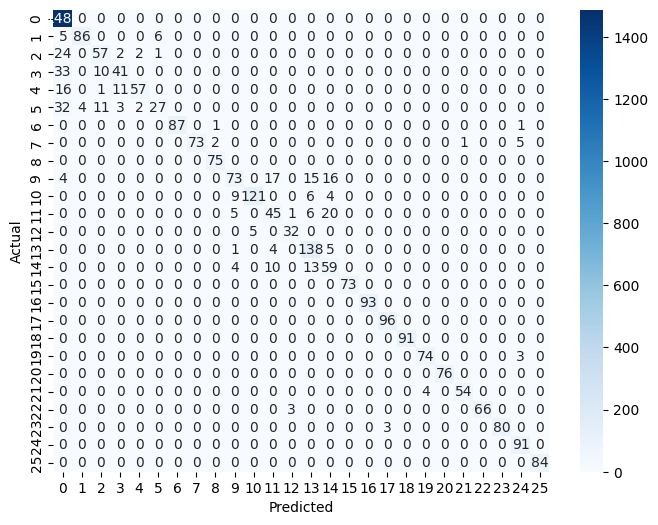

In [18]:
# Plot the confusion matrix
class_names = np.unique(y)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()

In [ ]:
# Save the trained model
model.save("my_model_24.h5")